In [1]:
pip install numpy==1.26.4 torch transformers==4.48.2 scikit-learn accelerate==0.26.0 matplotlib tqdm pandas seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 192.0 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 883.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 691.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 580.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 854.2 kB/s eta 0:00:0000:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 509.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 221.8 kB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 189.9 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.7/270.7 kB 246.6 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 214.6 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
# [IMPORT & SETUP SAMA SEPERTI SEBELUMNYA]
import os, glob, random, gc, json
import numpy as np, pandas as pd
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from transformers import (BertTokenizer, BertForSequenceClassification,
                          Trainer, TrainingArguments, set_seed, TrainerCallback)

# === CONFIGURATION ===
DATA_DIR    = "/workspace/SPLIT_BEATS_NPY/train"
LABEL_MAP   = {'N':0,'L':1,'R':2,'V':3,'Q':4}
MODEL_NAME  = "bert-base-uncased"
SEED        = 42
N_SPLITS    = 5
EPOCHS      = 20
MAX_LEN     = 512
OUTPUT_BASE = "/workspace/HASIL_BERT_tuned/HASIL_1"

HYPERPARAMS = {
    "lr": 2e-5,
    "batch_size": 32,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1
}

set_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cls_names = list(LABEL_MAP.keys())

# === UTIL ===
def signal_to_text(sig):
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8) * 255).astype(int)
    return " ".join(map(str, norm.tolist()))

def compute_metrics_fn(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average='macro')
    }

# === CALLBACK FOR LOGGING METRICS ===
class MetricsLoggerCallback(TrainerCallback):
    def __init__(self, trainer_ref, train_ds, val_ds):
        super().__init__()
        self.trainer = trainer_ref
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.history = []

    def on_epoch_end(self, args, state, control, **kwargs):
        epoch = state.epoch

        train_preds = self.trainer.predict(self.train_ds)
        train_labels = train_preds.label_ids
        train_logits = train_preds.predictions
        train_acc = accuracy_score(train_labels, np.argmax(train_logits, axis=1))

        val_preds = self.trainer.predict(self.val_ds)
        val_labels = val_preds.label_ids
        val_logits = val_preds.predictions
        val_acc = accuracy_score(val_labels, np.argmax(val_logits, axis=1))
        val_loss = val_preds.metrics["test_loss"]

        # Get train loss manually
        train_loss = None
        for log in reversed(self.trainer.state.log_history):
            if 'loss' in log and 'epoch' in log and log['epoch'] == epoch:
                train_loss = log['loss']
                break

        self.history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc
        })

# === LOAD & TOKENIZE DATA ===
files, labels = [], []
for cls, idx in LABEL_MAP.items():
    for f in glob.glob(os.path.join(DATA_DIR, cls, "*.npy")):
        files.append(f); labels.append(idx)
files, labels = np.array(files), np.array(labels)

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
all_ids, all_mask = [], []
for f in files:
    txt = signal_to_text(np.load(f))
    enc = tokenizer(txt, padding="max_length", truncation=True,
                    max_length=MAX_LEN, return_tensors="pt")
    all_ids.append(enc["input_ids"].squeeze(0))
    all_mask.append(enc["attention_mask"].squeeze(0))
all_ids  = torch.stack(all_ids)
all_mask = torch.stack(all_mask)
labels_t = torch.tensor(labels)

# === 5-FOLD TRAINING ===
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
summary_per_fold = []

for fold, (train_idx, test_idx) in enumerate(skf.split(all_ids, labels), 1):
    print(f"\n=== Fold {fold}/{N_SPLITS} ===")
    gc.collect(); torch.cuda.empty_cache()

    X_train, X_test = all_ids[train_idx], all_ids[test_idx]
    M_train, M_test = all_mask[train_idx], all_mask[test_idx]
    Y_train, Y_test = labels_t[train_idx], labels_t[test_idx]

    # Split train into train/val (80/20)
    tr_idx, val_idx = train_test_split(np.arange(len(X_train)), test_size=0.2, stratify=Y_train, random_state=SEED)
    Xtr, Xval = X_train[tr_idx], X_train[val_idx]
    Mtr, Mval = M_train[tr_idx], M_train[val_idx]
    Ytr, Yval = Y_train[tr_idx], Y_train[val_idx]

    train_ds = torch.utils.data.TensorDataset(Xtr, Mtr, Ytr)
    val_ds   = torch.utils.data.TensorDataset(Xval, Mval, Yval)
    test_ds  = torch.utils.data.TensorDataset(X_test, M_test, Y_test)

    def collate_fn(batch):
        ids, msk, lbl = map(torch.stack, zip(*batch))
        return {"input_ids": ids, "attention_mask": msk, "labels": lbl}

    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=len(LABEL_MAP)
    ).to(DEVICE)

    fold_dir = os.path.join(OUTPUT_BASE, f"fold{fold}")
    os.makedirs(fold_dir, exist_ok=True)

    args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        learning_rate=HYPERPARAMS["lr"],
        weight_decay=HYPERPARAMS["weight_decay"],
        warmup_ratio=HYPERPARAMS["warmup_ratio"],
        per_device_train_batch_size=HYPERPARAMS["batch_size"],
        per_device_eval_batch_size=HYPERPARAMS["batch_size"],
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        logging_strategy="epoch",
        seed=SEED,
        report_to=[]
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        data_collator=collate_fn,
        compute_metrics=compute_metrics_fn
    )

    cb = MetricsLoggerCallback(trainer, train_ds, val_ds)
    trainer.add_callback(cb)

    trainer.train()
    model.eval()

    # Simpan log per epoch
    hist_df = pd.DataFrame(cb.history)
    hist_df.to_csv(os.path.join(fold_dir, "history_epoch.csv"), index=False)

    # Evaluasi di test set
    test_pred = trainer.predict(test_ds)
    y_true = Y_test.cpu().numpy()
    y_pred = np.argmax(test_pred.predictions, axis=1)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(cls_names))))
    per_cls = {}
    for i, cls in enumerate(cls_names):
        TP = cm[i, i]
        FN = cm[i].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)
        acc = (TP + TN) / cm.sum()
        rec = TP / (TP + FN + 1e-8)
        spec = TN / (TN + FP + 1e-8)
        f1 = f1_score(y_true, y_pred, labels=[i], average='macro')
        per_cls[cls] = {'ACC': acc, 'F1': f1, 'REC': rec, 'SPEC': spec}

    # Confusion matrix gambar
    plt.figure(figsize=(6,5))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.xticks(range(len(cls_names)), cls_names)
    plt.yticks(range(len(cls_names)), cls_names)
    for r in range(len(cm)):
        for c in range(len(cm)):
            plt.text(c, r, cm[r,c], ha='center', va='center', color='black', fontsize=9)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    pd.DataFrame(per_cls).T.to_csv(os.path.join(fold_dir, "metrics_per_class.csv"))
    summary_per_fold.append(per_cls)

# === SUMMARY ===
summary = {c: {m: [] for m in ['ACC','F1','REC','SPEC']} for c in cls_names}
for fm in summary_per_fold:
    for c in cls_names:
        for m in summary[c]:
            summary[c][m].append(fm[c][m])

df_summary = pd.DataFrame({
    c: {m: f"{np.mean(v):.3f}±{np.std(v):.3f}" for m, v in summary[c].items()}
    for c in cls_names
}).T

print("\n===== Mean ± Std Final Metrics (Test Set per Fold) =====\n", df_summary)
df_summary.to_csv(os.path.join(OUTPUT_BASE, "final_summary_best_only.csv"))


=== Fold 1/5 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.031100,0.257011,0.936830,0.936762
2,0.172500,0.119348,0.966518,0.966491
3,0.102700,0.101566,0.976339,0.976328
4,0.071000,0.096027,0.978571,0.978635
5,0.051100,0.087305,0.981250,0.981199
6,0.033100,0.085461,0.982589,0.982615
7,0.023800,0.073698,0.986384,0.986406
8,0.017100,0.079244,0.984375,0.984430
9,0.012300,0.077762,0.986161,0.986152
10,0.009100,0.097904,0.983929,0.983964



=== Fold 2/5 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.033400,0.294480,0.926339,0.926432
2,0.178000,0.132416,0.961830,0.962055
3,0.105600,0.096253,0.976562,0.976551
4,0.070100,0.085349,0.978125,0.978092
5,0.049800,0.076562,0.983259,0.983326
6,0.036700,0.082515,0.981250,0.981314
7,0.022700,0.092580,0.981920,0.981895
8,0.016200,0.081709,0.984821,0.984859
9,0.009400,0.103208,0.983482,0.983552
10,0.009400,0.119599,0.980580,0.980592



=== Fold 3/5 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.028300,0.264968,0.934152,0.933981
2,0.189800,0.113348,0.969866,0.969951
3,0.115500,0.100008,0.975223,0.975107
4,0.075400,0.071134,0.984152,0.984140
5,0.054100,0.081393,0.983259,0.983204
6,0.034400,0.081561,0.982812,0.982784
7,0.026900,0.079095,0.983929,0.983918
8,0.022000,0.068228,0.987054,0.987035
9,0.014300,0.077799,0.987277,0.987273
10,0.008900,0.105048,0.984152,0.984145



=== Fold 4/5 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.038900,0.281838,0.925446,0.925766
2,0.172400,0.127670,0.957143,0.957334
3,0.102400,0.095084,0.974777,0.974703
4,0.068900,0.080191,0.981920,0.981889
5,0.043900,0.088493,0.978795,0.978778
6,0.032200,0.099646,0.979241,0.979303
7,0.022400,0.082234,0.983705,0.983742
8,0.016600,0.084427,0.984152,0.984147
9,0.011400,0.080616,0.985714,0.985729
10,0.007500,0.096763,0.984152,0.984166



=== Fold 5/5 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.046600,0.280701,0.927232,0.926773
2,0.179200,0.131724,0.962946,0.963078
3,0.101500,0.068365,0.981920,0.981924
4,0.064300,0.077420,0.982812,0.982836
5,0.046500,0.079958,0.982812,0.982883
6,0.033600,0.069245,0.985714,0.985724
7,0.022400,0.065993,0.986607,0.986622
8,0.020300,0.069511,0.986384,0.986393
9,0.014500,0.064821,0.986384,0.986364
10,0.005600,0.070009,0.988839,0.988842



===== Mean ± Std Final Metrics (Test Set per Fold) =====
            ACC           F1          REC         SPEC
N  0.993±0.002  0.983±0.004  0.981±0.004  0.996±0.001
L  0.997±0.000  0.991±0.001  0.991±0.003  0.998±0.001
R  0.998±0.001  0.995±0.002  0.995±0.002  0.999±0.001
V  0.992±0.002  0.980±0.004  0.983±0.006  0.994±0.001
Q  0.998±0.001  0.995±0.001  0.994±0.002  0.999±0.000


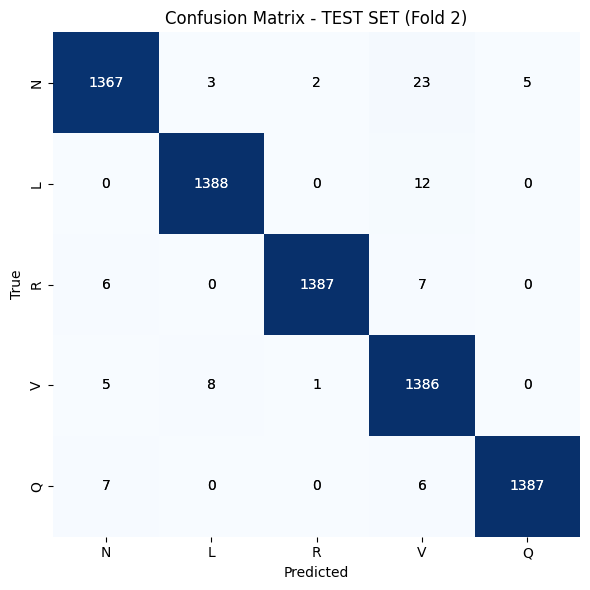


📁 Hasil evaluasi disimpan di: D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_TRAIN\BEATS\Bert beat tuned\fold2\checkpoint-7840\test_metrics_perclass.csv
   Accuracy    Recall  Specificity  F1-Score
N  0.992714  0.976429     0.996786  0.981688
L  0.996714  0.991429     0.998036  0.991783
R  0.997714  0.990714     0.999464  0.994265
V  0.991143  0.990000     0.991429  0.978123
Q  0.997429  0.990714     0.999107  0.993553


In [2]:
import os, glob
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification

# === KONFIGURASI ===
DATA_DIR    = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\DATA\output_coba\SPLIT_BEATS_NPY\Beats_TEST"
MODEL_PATH  = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_TRAIN\BEATS\Bert beat tuned\fold2\checkpoint-7840"
LABEL_MAP   = {'N': 0, 'L': 1, 'R': 2, 'V': 3, 'Q': 4}
MAX_LEN     = 512
MODEL_NAME  = "bert-base-uncased"
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cls_names   = list(LABEL_MAP.keys())

# === FUNGSI PEMROSESAN SINYAL ===
def signal_to_text(sig):
    norm = ((sig - sig.min()) / (sig.ptp() + 1e-8) * 255).astype(int)
    return " ".join(map(str, norm.tolist()))

# === LOAD TEST DATA ===
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
files, labels = [], []
for cls, idx in LABEL_MAP.items():
    cls_folder = os.path.join(DATA_DIR, cls)
    for f in glob.glob(os.path.join(cls_folder, "*.npy")):
        files.append(f)
        labels.append(idx)
files, labels = np.array(files), np.array(labels)

all_ids, all_mask = [], []
for f in files:
    txt = signal_to_text(np.load(f))
    enc = tokenizer(txt, padding="max_length", truncation=True,
                    max_length=MAX_LEN, return_tensors="pt")
    all_ids.append(enc["input_ids"].squeeze(0))
    all_mask.append(enc["attention_mask"].squeeze(0))
all_ids  = torch.stack(all_ids)
all_mask = torch.stack(all_mask)
labels_t = torch.tensor(labels)

# === LOAD MODEL ===
model = BertForSequenceClassification.from_pretrained(MODEL_PATH).to(DEVICE)
model.eval()

# === INFERENSI ===
y_pred = []
with torch.no_grad():
    for i in range(0, len(all_ids), 32):
        ids = all_ids[i:i+32].to(DEVICE)
        msk = all_mask[i:i+32].to(DEVICE)
        outputs = model(input_ids=ids, attention_mask=msk)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

y_true = labels_t.numpy()
y_pred = np.array(y_pred)

# === CONFUSION MATRIX DENGAN WARNA PUTIH UNTUK DIAGONAL ===
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(cls_names))))
plt.figure(figsize=(6, 6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=cls_names, yticklabels=cls_names, cbar=False)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if i == j else "black"
        ax.text(j + 0.5, i + 0.5, format(cm[i, j], "d"),
                ha="center", va="center", color=color, fontsize=10)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - TEST SET (Fold 2)")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, "confusion_matrix_test.png"))
plt.show()

# === METRIK PER KELAS ===
per_cls = {}
for i, cls in enumerate(cls_names):
    TP = cm[i, i]
    FN = cm[i].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)
    acc  = (TP + TN) / cm.sum()
    rec  = TP / (TP + FN + 1e-8)
    spec = TN / (TN + FP + 1e-8)
    f1   = f1_score(y_true, y_pred, labels=[i], average='macro')
    per_cls[cls] = {'Accuracy': acc, 'Recall': rec, 'Specificity': spec, 'F1-Score': f1}

# === SIMPAN HASIL ===
df = pd.DataFrame(per_cls).T
df_path = os.path.join(MODEL_PATH, "test_metrics_perclass.csv")
df.to_csv(df_path)
print(f"\n📁 Hasil evaluasi disimpan di: {df_path}")
print(df)
